In [13]:
import sys
import pandas as pd
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

sys.path.append(str(Path("..").resolve()))
from src.visualizations import setup_tueplots, plot_wind_power_composition
from src.preprocessing import Column, preprocess_supply_data
from src.checkpoint import save_checkpoint, load_checkpoint


In [2]:
path = Path('..') / 'data' / 'Realised_Supply_Germany.csv'
df = pd.read_csv(path, sep=';', decimal=',')

In [3]:
df = preprocess_supply_data(df, resample="h")

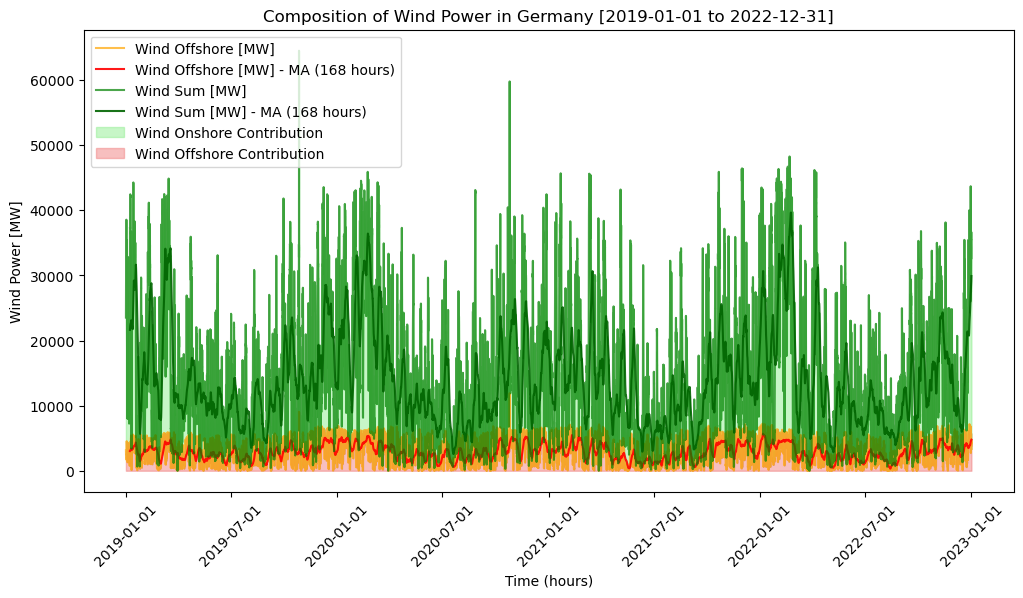

In [4]:
fig = plot_wind_power_composition(
    dates=df.index,
    wind_offshore=df[Column.WIND_OFFSHORE.value],
    wind_onshore=df[Column.WIND_ONSHORE.value],
    moving_average_window=24*7
)

In [5]:
# Train test split
df = df[[Column.WIND.value]].copy()

scaler = StandardScaler()
df[Column.WIND.value] = scaler.fit_transform(df[Column.WIND.value].values.reshape(-1, 1))

# Split the data into training and test sets
split_date = "2022-01-01"
start_date = df.index[0]
end_date = df.index[-1]
train_data = df["2021-01-01":split_date]
test_data = df[split_date:end_date]
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2021-01-01 00:00:00 to 2022-01-01 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Wind Sum [MW]  8784 non-null   float64
dtypes: float64(1)
memory usage: 137.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Wind Sum [MW]  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


In [6]:
def create_time_features(df: pd.DataFrame):
    """
    Create time-based features from the datetime index of the dataframe.
    
    Args:
        df: DataFrame with DatetimeIndex
        
    Returns:
        DataFrame with time features added
    """
    df_with_features = df.copy()
    
    # Add cyclical time features using sine and cosine transformations
    # Hour of day (24 hours)
    df_with_features['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df_with_features['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    
    # Day of week (7 days)
    df_with_features['dayofweek_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df_with_features['dayofweek_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # Month of year (12 months)
    df_with_features['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df_with_features['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    
    # Day of year (365 days)
    df_with_features['dayofyear_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
    df_with_features['dayofyear_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)
    
    return df_with_features

# Create a function to generate the training and test sets
def create_sliding_window_data(data: pd.DataFrame, history: int, forecast_horizon: int):
    """
    Create sliding window data for time series forecasting.
    
    Args:
        data: DataFrame with time series data
        history: Number of past time steps to use as input
        forecast_horizon: Number of future time steps to predict
    Returns:
        X: Input data - features of shape (samples, history, features)
        y: Target data - labels of shape (samples, forecast_horizon)
    """
    X, y = [], []
    for i in range(len(data) - history - forecast_horizon + 1):
        history_data = data.iloc[i : i + history].values
        future_data = data.iloc[i + history : i + history + forecast_horizon][
            Column.WIND.value
        ].values
        X.append(history_data)
        y.append(future_data)
    return np.array(X), np.array(y)

In [7]:
# Sliding window training
HISTORY_LENGTH = 24  # 168 hours = 7 days (lag features)
FORECAST_HORIZON = 24  # 24 hours

# train = create_time_features(train_data.copy())
# test = create_time_features(test_data.copy())
train = train_data.copy()
test = test_data.copy()

X, y = create_sliding_window_data(train, history=HISTORY_LENGTH, forecast_horizon=FORECAST_HORIZON)
X_test, y_test = create_sliding_window_data(
    test, history=HISTORY_LENGTH, forecast_horizon=FORECAST_HORIZON
)
X.shape, y.shape, X_test.shape, y_test.shape


((8737, 24, 1), (8737, 24), (8713, 24, 1), (8713, 24))

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
float_precision = np.float32
# Flatten lag and feature dimensions
X = X.reshape(X.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

X = torch.tensor(X, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

X.shape, y.shape, X_test.shape, y_test.shape


(torch.Size([8737, 24]),
 torch.Size([8737, 24]),
 torch.Size([8713, 24]),
 torch.Size([8713, 24]))

In [10]:
class SparseGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # Variational Distribution & Strategy
        variational_dist = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_dist, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + 
            gpytorch.kernels.PeriodicKernel() +
            gpytorch.kernels.LinearKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [12]:
# ---------------------------------------
# 2. Define Sparse GP Model for Multi-step Forecasting
# ---------------------------------------

M_INDUCING_POINTS = 500
LOAD_PRETRAINED = True
CHECKPOINT_NAME = "checkpoint_v0"

models = []
likelihoods = []
mlls = []
optimizers = []

inducing_points_candidates = X[
    torch.randperm(X.size(0))[: max(M_INDUCING_POINTS, X.size(0))]
]  # Ensure we don't exceed X size

for h in range(FORECAST_HORIZON):
    # print(f"Initializing model for forecast step {h+1}/{FORECAST_HORIZON}")
    # Select M inducing points for each model (can be shared or different)
    # For simplicity, let's use the same candidate set and select from it,
    # or re-sample. Here, we re-sample for each.
    current_inducing_points = inducing_points_candidates[
        torch.randperm(inducing_points_candidates.size(0))[:M_INDUCING_POINTS]
    ]

    model_h = SparseGPModel(current_inducing_points).to(device)
    likelihood_h = gpytorch.likelihoods.GaussianLikelihood().to(device)
    mll_h = gpytorch.mlls.VariationalELBO(
        likelihood_h, model_h, num_data=X.size(0)
    ).to(device)

    optimizer_h = torch.optim.Adam(
        [
            {"params": model_h.parameters()},
            {"params": likelihood_h.parameters()},
        ],
        lr=0.01,
    )
    
    if LOAD_PRETRAINED:
        epoch = load_checkpoint(model_h, likelihood_h, optimizer_h, h, CHECKPOINT_NAME)
        print(f"Loaded checkpoint for horizon {h} at epoch {epoch}.")

    models.append(model_h)
    likelihoods.append(likelihood_h)
    mlls.append(mll_h)
    optimizers.append(optimizer_h)

print(f"\nInitialized {len(models)} models.")


Loaded checkpoint for horizon 0 at epoch 401.
Loaded checkpoint for horizon 1 at epoch 401.
Loaded checkpoint for horizon 2 at epoch 401.
Loaded checkpoint for horizon 3 at epoch 401.
Loaded checkpoint for horizon 4 at epoch 401.
Loaded checkpoint for horizon 5 at epoch 401.
Loaded checkpoint for horizon 6 at epoch 401.
Loaded checkpoint for horizon 7 at epoch 401.
Loaded checkpoint for horizon 8 at epoch 401.
Loaded checkpoint for horizon 9 at epoch 401.
Loaded checkpoint for horizon 10 at epoch 401.
Loaded checkpoint for horizon 11 at epoch 401.
Loaded checkpoint for horizon 12 at epoch 401.
Loaded checkpoint for horizon 13 at epoch 401.
Loaded checkpoint for horizon 14 at epoch 401.
Loaded checkpoint for horizon 15 at epoch 401.
Loaded checkpoint for horizon 16 at epoch 401.
Loaded checkpoint for horizon 17 at epoch 401.
Loaded checkpoint for horizon 18 at epoch 401.
Loaded checkpoint for horizon 19 at epoch 401.
Loaded checkpoint for horizon 20 at epoch 401.
Loaded checkpoint for h

In [ ]:
# ---------------------------------------
# 3. Train the Sparse GP models (one for each forecast horizon step)
# ---------------------------------------
NUM_EPOCHS = 1

for h in range(FORECAST_HORIZON):
    print(f"\nTraining model for forecast step {h+1}/{FORECAST_HORIZON}...")
    model = models[h]
    likelihood = likelihoods[h]
    mll = mlls[h]
    optimizer = optimizers[h]

    # Get the target for the current forecast step
    current_train_y = y[:, h]

    model.train()
    likelihood.train()

    total_epoch = 400
    for epoch in tqdm(range(NUM_EPOCHS)):
        total_epoch += 1
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, current_train_y)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 200 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1}/{NUM_EPOCHS} - ELBO Loss: {loss.item():.3f}")

    # Save the model checkpoint
    checkpoint_name = "checkpoint_v0"
    save_checkpoint(total_epoch, h, model, likelihood, optimizer, checkpoint_name)



Predicted means shape: (8713, 24)
True test Y shape: (8713, 24)
Average Test RMSE across horizon: 6268.734


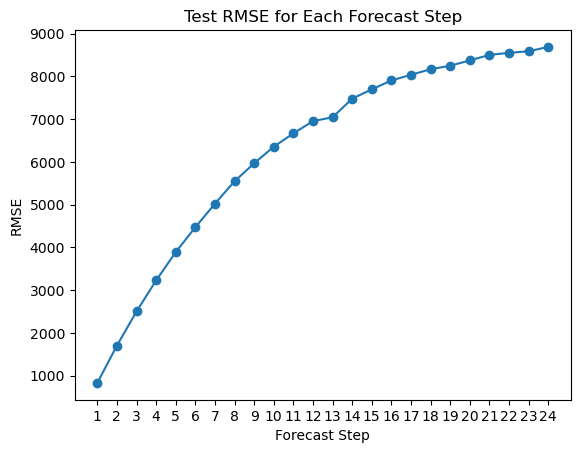

In [14]:
# ---------------------------------------
# 4. Evaluate on Test Data
# ---------------------------------------
all_means_test = []
all_vars_test = []

for h in range(FORECAST_HORIZON):
    # print(f"Evaluating model for forecast step {h+1}/{FORECAST_HORIZON}...")
    model = models[h]
    likelihood = likelihoods[h]

    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # test_x are the lagged features from the test set
        preds_h = likelihood(model(X_test))
        mean_h = preds_h.mean.cpu().numpy()
        var_h = preds_h.variance.cpu().numpy()

    all_means_test.append(mean_h)
    all_vars_test.append(var_h)

# Stack predictions: results in shape (num_test_samples, FORECAST_HORIZON)
predicted_means_test = np.stack(all_means_test, axis=1)
predicted_vars_test = np.stack(all_vars_test, axis=1)

predicted_means_test = scaler.inverse_transform(predicted_means_test)
predicted_vars_test = scaler.inverse_transform(predicted_vars_test)
y_test = scaler.inverse_transform(y_test.cpu().numpy())
print(f"\nPredicted means shape: {predicted_means_test.shape}")  # Shape (# samples, H)
print(f"True test Y shape: {y_test.shape}")

# Compute RMSE for each forecast step
rmses_per_step = []
for h in range(FORECAST_HORIZON):
    true_h = y_test[:, h]
    pred_h = predicted_means_test[:, h]
    rmse_h = root_mean_squared_error(true_h, pred_h)
    rmses_per_step.append(rmse_h)
    # print(f"Test RMSE for step {h+1}: {rmse_h:.3f}")

print(f"Average Test RMSE across horizon: {np.mean(rmses_per_step):.3f}")

plt.plot(np.arange(1, FORECAST_HORIZON + 1), rmses_per_step, marker="o", label="RMSE")
plt.xticks(np.arange(1, FORECAST_HORIZON + 1))
plt.xlabel("Forecast Step")
plt.ylabel("RMSE")
plt.title("Test RMSE for Each Forecast Step")
plt.show()


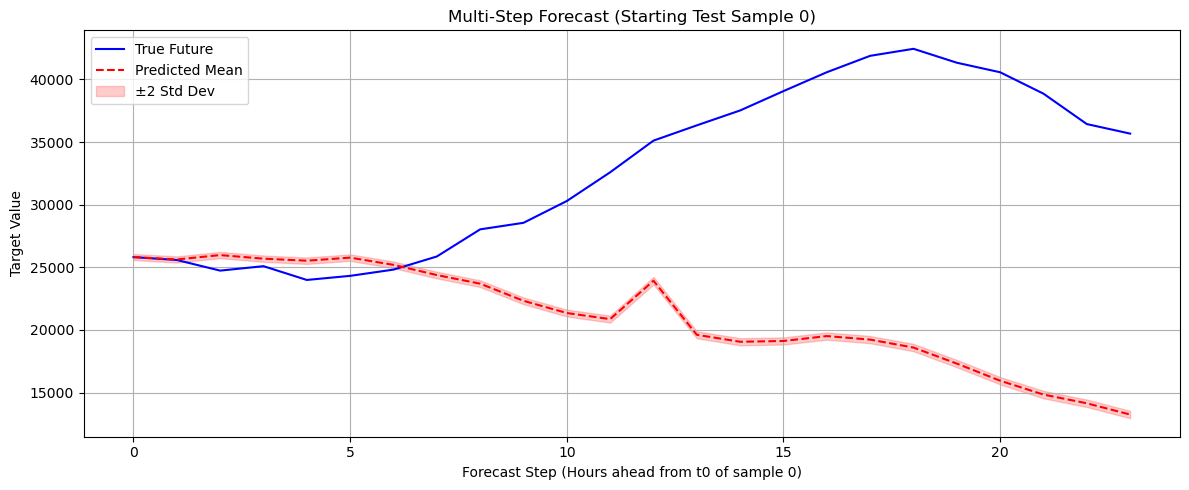

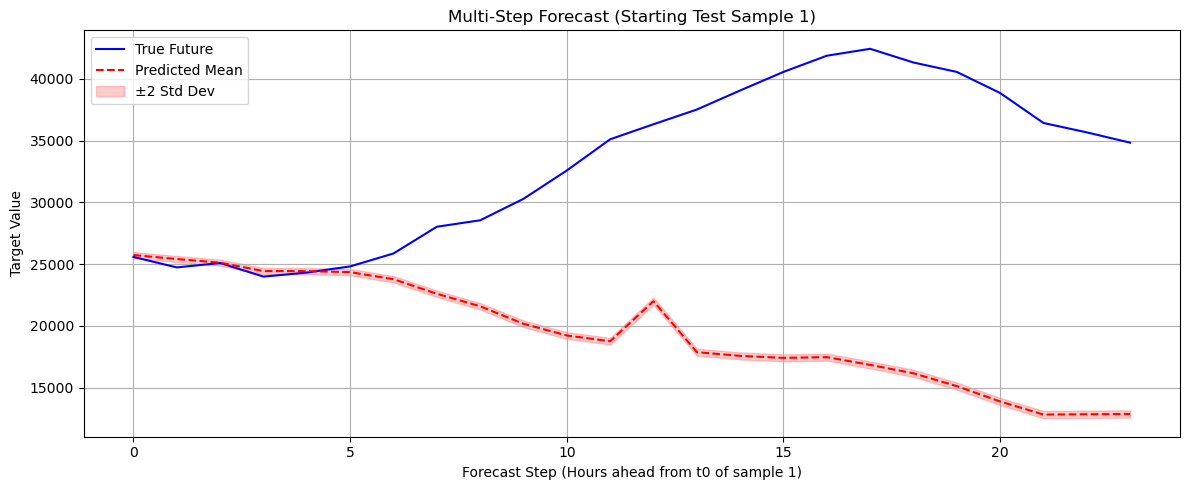

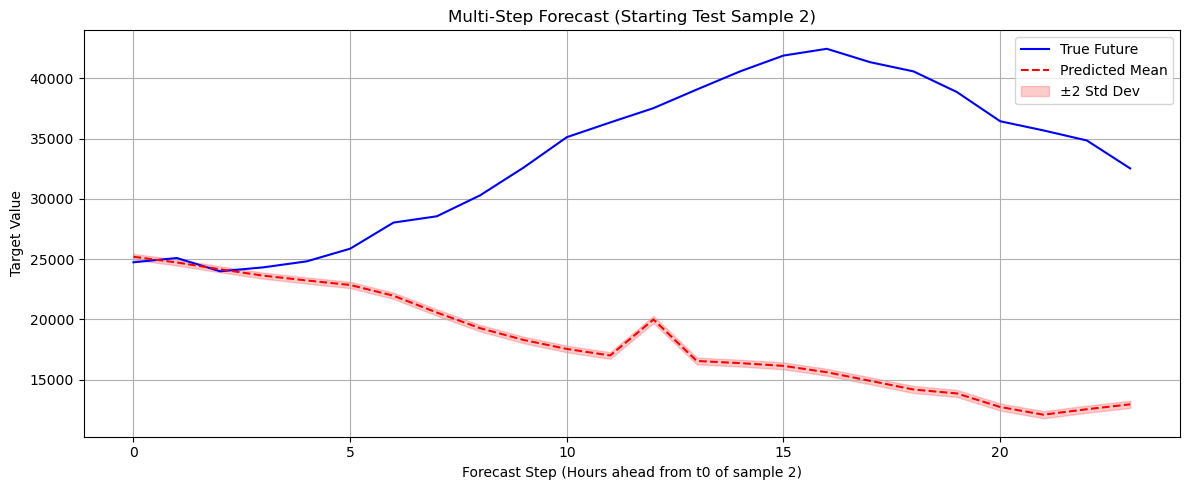

In [15]:
# ---------------------------------------
# 5. Plot Results for a few forecast sequences
# ---------------------------------------

num_sequences_to_plot = 3

for i in range(num_sequences_to_plot):
    plt.figure(figsize=(12, 5))

    # Define the x-axis for the forecast horizon
    forecast_steps_axis = np.arange(FORECAST_HORIZON)

    # True future values for this sequence
    true_future_sequence = y_test[i, :]

    # Predicted future values for this sequence
    predicted_future_sequence = predicted_means_test[i, :]
    predicted_future_vars = predicted_vars_test[i, :]

    plt.plot(
        forecast_steps_axis, true_future_sequence, "b-", label="True Future"
    )
    plt.plot(
        forecast_steps_axis, predicted_future_sequence, "r--", label="Predicted Mean"
    )

    upper_bound = predicted_future_sequence + 2 * np.sqrt(predicted_future_vars)
    lower_bound = predicted_future_sequence - 2 * np.sqrt(predicted_future_vars)
    plt.fill_between(
        forecast_steps_axis,
        lower_bound,
        upper_bound,
        color="red",
        alpha=0.2,
        label="±2 Std Dev",
    )

    plt.title(f"Multi-Step Forecast (Starting Test Sample {i})")
    plt.xlabel(f"Forecast Step (Hours ahead from t0 of sample {i})")
    plt.ylabel("Target Value")
    # plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


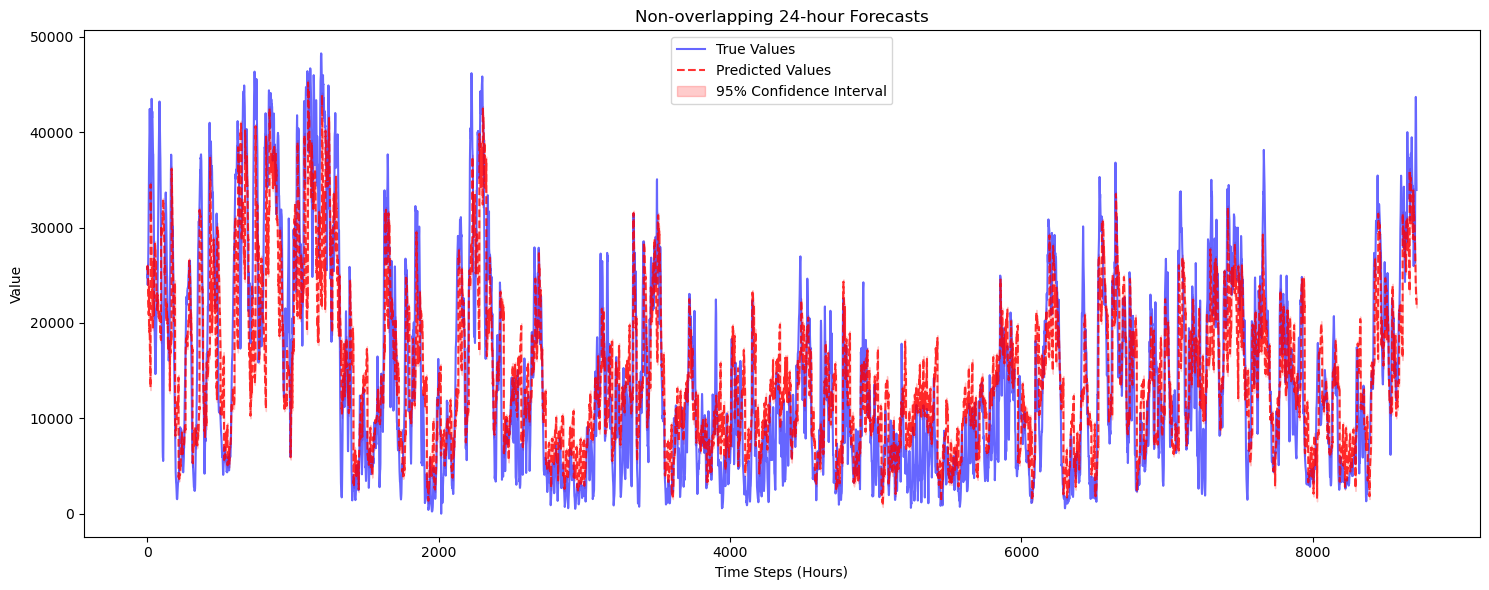

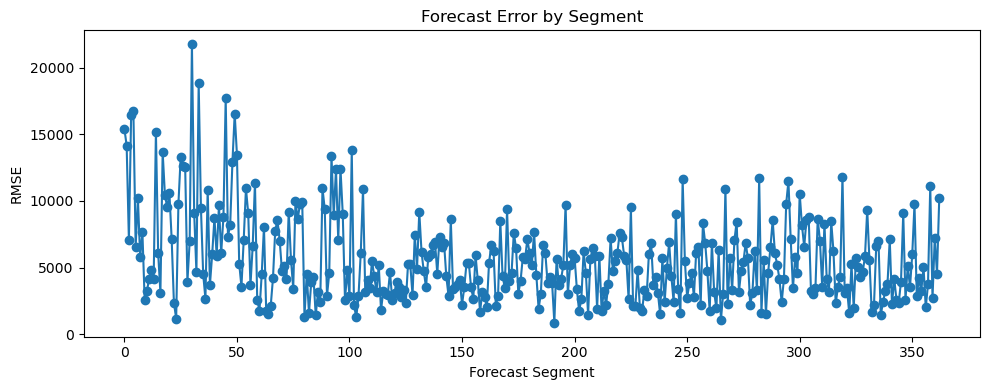

In [16]:
# ---------------------------------------
# 2. Plot along the entire test set
# ---------------------------------------

# Calculate how many non-overlapping 24-hour segments we can have
number_non_overlapping_test_samples = len(y_test) // FORECAST_HORIZON

# Create time axis for the entire plot
time_axis = np.arange(number_non_overlapping_test_samples * FORECAST_HORIZON)

plt.figure(figsize=(15, 6))

# Extract actual values for the same time points we'll be forecasting
true_values = []
predicted_values = []
confidence_lower = []
confidence_upper = []

# For each non-overlapping segment
for i in range(number_non_overlapping_test_samples):
    # Get the index in the test data
    idx = i * FORECAST_HORIZON

    # Extract true values for this segment
    segment_true = y_test[idx]
    true_values.extend(segment_true)

    # Extract predictions for this segment
    segment_predicted = predicted_means_test[idx]
    predicted_values.extend(segment_predicted)

    # Calculate confidence intervals
    segment_vars = predicted_vars_test[idx]
    segment_lower = segment_predicted - 2 * np.sqrt(segment_vars)
    segment_upper = segment_predicted + 2 * np.sqrt(segment_vars)
    confidence_lower.extend(segment_lower)
    confidence_upper.extend(segment_upper)

# Convert to numpy arrays
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)
confidence_lower = np.array(confidence_lower)
confidence_upper = np.array(confidence_upper)

# Plot true values
plt.plot(time_axis, true_values, "b-", label="True Values", alpha=0.6)

# Plot predicted values
plt.plot(time_axis, predicted_values, "r--", label="Predicted Values", alpha=0.8)

# Plot confidence intervals
plt.fill_between(
    time_axis,
    confidence_lower,
    confidence_upper,
    color="red",
    alpha=0.2,
    label="95% Confidence Interval",
)

# Add vertical lines to separate the 24-hour segments
# for i in range(1, number_non_overlapping_test_samples):
#     plt.axvline(x=i * FORECAST_HORIZON, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Time Steps (Hours)")
plt.ylabel("Value")
plt.title("Non-overlapping 24-hour Forecasts")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Display forecast metrics for each segment
segment_rmses = []
for i in range(number_non_overlapping_test_samples):
    idx = i * FORECAST_HORIZON
    segment_true = y_test[idx]
    segment_predicted = predicted_means_test[idx]
    segment_rmse = root_mean_squared_error(segment_true, segment_predicted)
    segment_rmses.append(segment_rmse)

plt.figure(figsize=(10, 4))
plt.plot(np.arange(number_non_overlapping_test_samples), segment_rmses, marker="o")
plt.xlabel("Forecast Segment")
plt.ylabel("RMSE")
plt.title("Forecast Error by Segment")
plt.tight_layout()
plt.show()


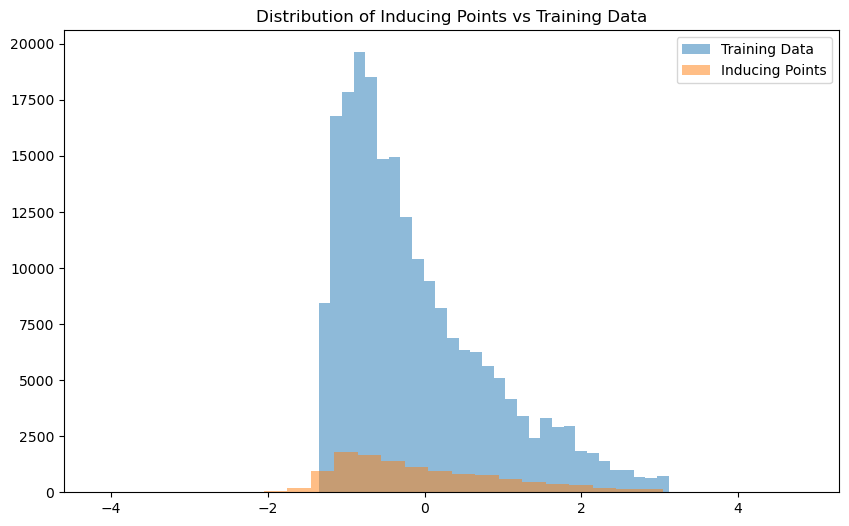

In [17]:
def visualize_inducing_points(model, X_train):
    # Plot the distribution of inducing points vs. training data
    plt.figure(figsize=(10, 6))
    plt.hist(X_train.cpu().numpy().flatten(), bins=30, alpha=0.5, label="Training Data")
    plt.hist(
        model.variational_strategy.inducing_points.cpu().detach().numpy().flatten(),
        bins=30,
        alpha=0.5,
        label="Inducing Points",
    )
    plt.legend()
    plt.title("Distribution of Inducing Points vs Training Data")
    plt.show()

visualize_inducing_points(models[0], X)